# 14.1d: Black Hole Demographics Over Time

**How does the dead token clustering structure evolve?**

## The Question

Dead tokens perform a Brownian walk on the bfloat16 lattice. As they randomly collide, black holes (degenerate token clusters) form and dissolve. We want to understand:

1. How does the population distribution change over time?
2. Is the hierarchy stable (same black holes grow) or dynamic (rankings shuffle)?
3. Do black holes merge (fewer, larger) or fragment (more, smaller)?
4. Does inequality increase (one dominant cluster) or decrease (uniform distribution)?

## Definitions

- **Black hole**: A unique vector with population ≥ 2 (multiple dead tokens at same location)
- **Singleton**: A unique vector with population = 1 (isolated dead token)

We track only black holes. Singletons are not black holes.

## Data Source

Uses the 10,001-step instrumented run from 14.1a (steps 0-10,000, sampled every 10 steps).

## Parameters

In [43]:
# Data (from 14.1a instrumented run)
DATA_PATH = "../data/instrumented_run/gradient_delta_history.safetensors"

# Analysis
MAX_RANKS_TO_PLOT = 5  # Show top N black holes by rank

# Visualization
DPI = 100
COLORMAP = 'hsv'

RANDOM_SEED = 42

## Imports

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from safetensors.torch import load_file
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

We need to reconstruct embeddings from the gradient/delta history.

In [45]:
print(f"Loading: {DATA_PATH}")

data = load_file(DATA_PATH)

recorded_steps = data['recorded_steps'].numpy()
dead_token_ids = data['dead_token_ids'].tolist()
dead_deltas = data['dead_deltas']  # [n_recorded, n_dead, hidden_dim]

n_recorded, n_dead, hidden_dim = dead_deltas.shape

print(f"\n  Recorded steps: {n_recorded}")
print(f"  Step range: {recorded_steps[0]} to {recorded_steps[-1]}")
print(f"  Dead tokens: {n_dead}")
print(f"  Hidden dim: {hidden_dim}")
print(f"\n✓ Data loaded")

Loading: ../data/instrumented_run/gradient_delta_history.safetensors

  Recorded steps: 1001
  Step range: 0 to 10000
  Dead tokens: 51
  Hidden dim: 64

✓ Data loaded


## Reconstruct Embedding Trajectories

We have deltas at each recorded step. Accumulate them to get absolute embeddings.

In [46]:
print("Reconstructing embedding trajectories...")

# Cumulative sum of deltas gives us position at each step
embedding_history = torch.cumsum(dead_deltas, dim=0)  # [n_recorded, n_dead, hidden_dim]

print(f"✓ Reconstructed embeddings: {embedding_history.shape}")

Reconstructing embedding trajectories...
✓ Reconstructed embeddings: torch.Size([1001, 51, 64])


## Compute Black Hole Demographics at Each Step

In [47]:
def get_black_hole_demographics(embeddings_bf16):
    """
    Given embeddings [n_dead, hidden_dim] in bfloat16,
    return sorted list of BLACK HOLE populations (pop >= 2, descending).
    Singletons (pop = 1) are NOT counted as black holes.
    """
    # Find unique vectors (using exact equality for bfloat16)
    unique_vectors = []
    populations = []
    
    for vec in embeddings_bf16:
        found = False
        for i, unique_vec in enumerate(unique_vectors):
            if torch.equal(vec, unique_vec):
                populations[i] += 1
                found = True
                break
        if not found:
            unique_vectors.append(vec)
            populations.append(1)
    
    # Filter to only black holes (population >= 2)
    black_hole_pops = [p for p in populations if p >= 2]
    
    # Sort by population (descending)
    black_hole_pops.sort(reverse=True)
    
    return black_hole_pops

# Compute demographics at ALL recorded steps
print("Computing black hole demographics at each step...")

demographics_over_time = []

for step_idx in tqdm(range(n_recorded)):
    embeddings_f32 = embedding_history[step_idx].float()
    embeddings_bf16 = embeddings_f32.to(torch.bfloat16)  # Quantize to match training
    demographics = get_black_hole_demographics(embeddings_bf16)
    demographics_over_time.append(demographics)

print(f"\n✓ Demographics computed for {n_recorded} steps")

Computing black hole demographics at each step...


100%|██████████| 1001/1001 [00:00<00:00, 7171.20it/s]


✓ Demographics computed for 1001 steps


## Plot 1: Ranked Black Hole Populations Over Time

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_98988/1764368400.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(COLORMAP)(np.linspace(0, 1, n_ranks))


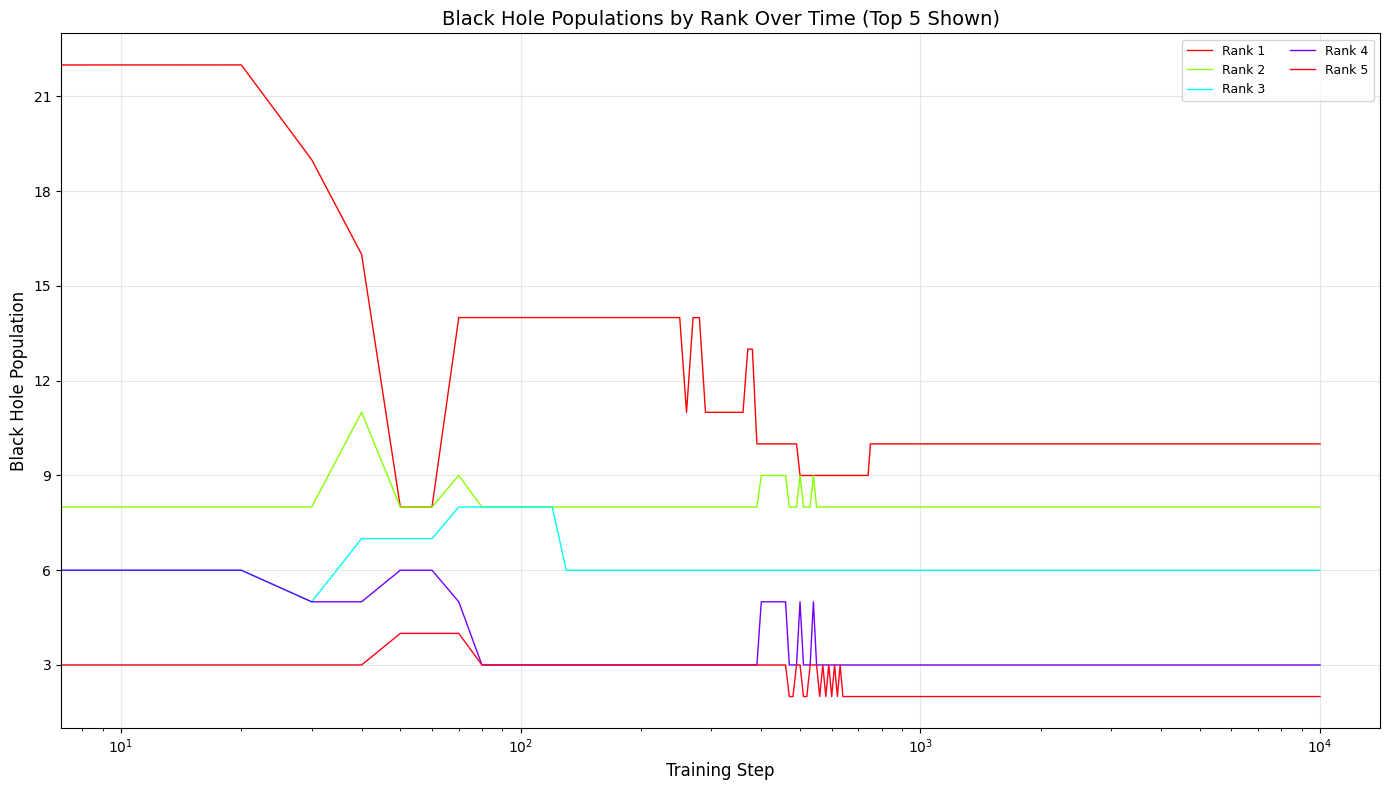


✓ Ranked populations plot complete


In [53]:
# Prepare data: for each rank, track population over time
max_black_holes = max(len(d) for d in demographics_over_time)
n_ranks = min(MAX_RANKS_TO_PLOT, max_black_holes)

# Pad demographics to same length (fill with 0 for missing ranks)
populations_by_rank = np.zeros((n_recorded, n_ranks))

for i, demographics in enumerate(demographics_over_time):
    for rank in range(min(n_ranks, len(demographics))):
        populations_by_rank[i, rank] = demographics[rank]

# Plot
fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

colors = plt.cm.get_cmap(COLORMAP)(np.linspace(0, 1, n_ranks))

for rank in range(n_ranks):
    ax.plot(recorded_steps, populations_by_rank[:, rank], 
            linewidth=1, color=colors[rank], label=f'Rank {rank+1}')

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Black Hole Population', fontsize=12)
ax.set_title(f'Black Hole Populations by Rank Over Time (Top {n_ranks} Shown)', fontsize=14)
ax.legend(loc='best', fontsize=9, ncol=2)
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

print(f"\n✓ Ranked populations plot complete")

## Plot 2: Demographics Comparison (First vs Last Step)

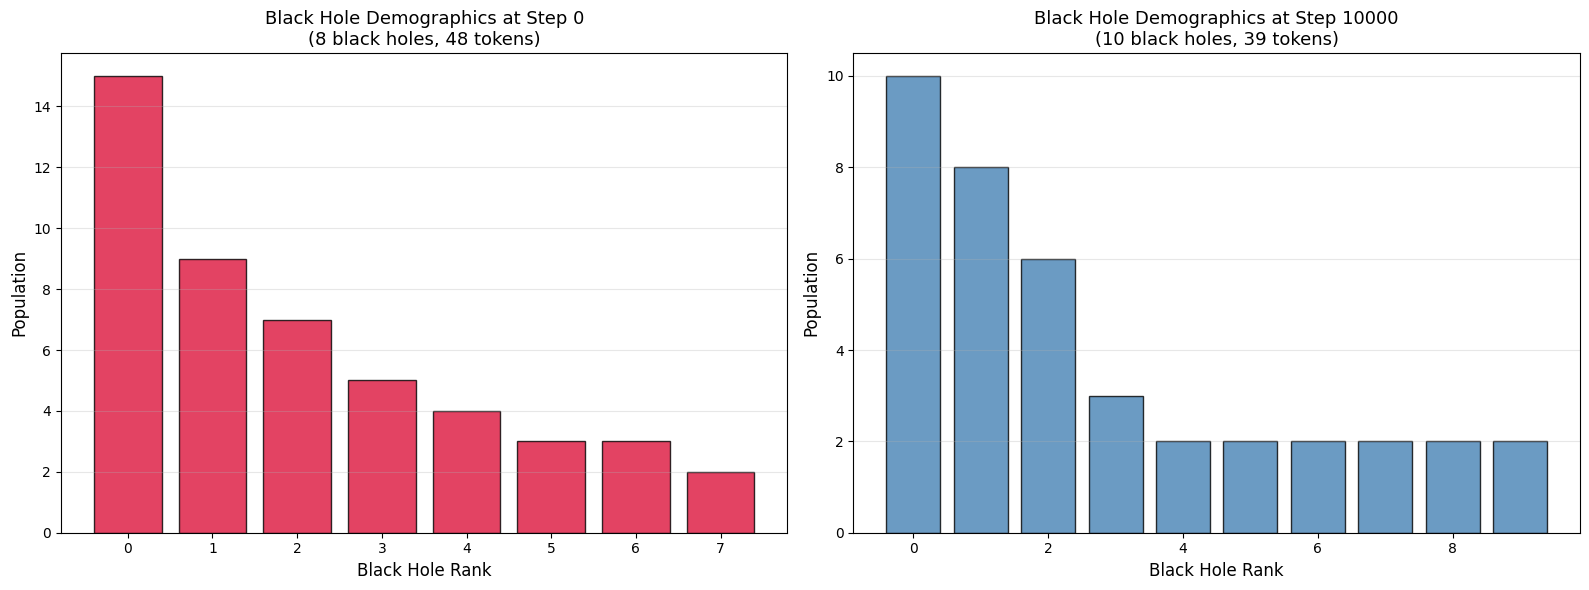


✓ Demographics comparison plot complete


In [54]:
# Get demographics at first and last steps
initial_demographics = demographics_over_time[0]
final_demographics = demographics_over_time[-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

# Left: t=0
if len(initial_demographics) > 0:
    axes[0].bar(range(len(initial_demographics)), initial_demographics, color='crimson', edgecolor='black', alpha=0.8)
    axes[0].set_title(f'Black Hole Demographics at Step {recorded_steps[0]}\n({len(initial_demographics)} black holes, {sum(initial_demographics)} tokens)', fontsize=13)
else:
    axes[0].text(0.5, 0.5, f'No black holes at step {recorded_steps[0]}', ha='center', va='center', transform=axes[0].transAxes, fontsize=14)
    axes[0].set_title(f'Black Hole Demographics at Step {recorded_steps[0]}\n(0 black holes)', fontsize=13)

axes[0].set_xlabel('Black Hole Rank', fontsize=12)
axes[0].set_ylabel('Population', fontsize=12)
axes[0].grid(alpha=0.3, axis='y')

# Right: Final step
if len(final_demographics) > 0:
    axes[1].bar(range(len(final_demographics)), final_demographics, color='steelblue', edgecolor='black', alpha=0.8)
    axes[1].set_title(f'Black Hole Demographics at Step {recorded_steps[-1]}\n({len(final_demographics)} black holes, {sum(final_demographics)} tokens)', fontsize=13)
else:
    axes[1].text(0.5, 0.5, f'No black holes at step {recorded_steps[-1]}', ha='center', va='center', transform=axes[1].transAxes, fontsize=14)
    axes[1].set_title(f'Black Hole Demographics at Step {recorded_steps[-1]}\n(0 black holes)', fontsize=13)

axes[1].set_xlabel('Black Hole Rank', fontsize=12)
axes[1].set_ylabel('Population', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Demographics comparison plot complete")

## Plot 3: Total Number of Black Holes Over Time

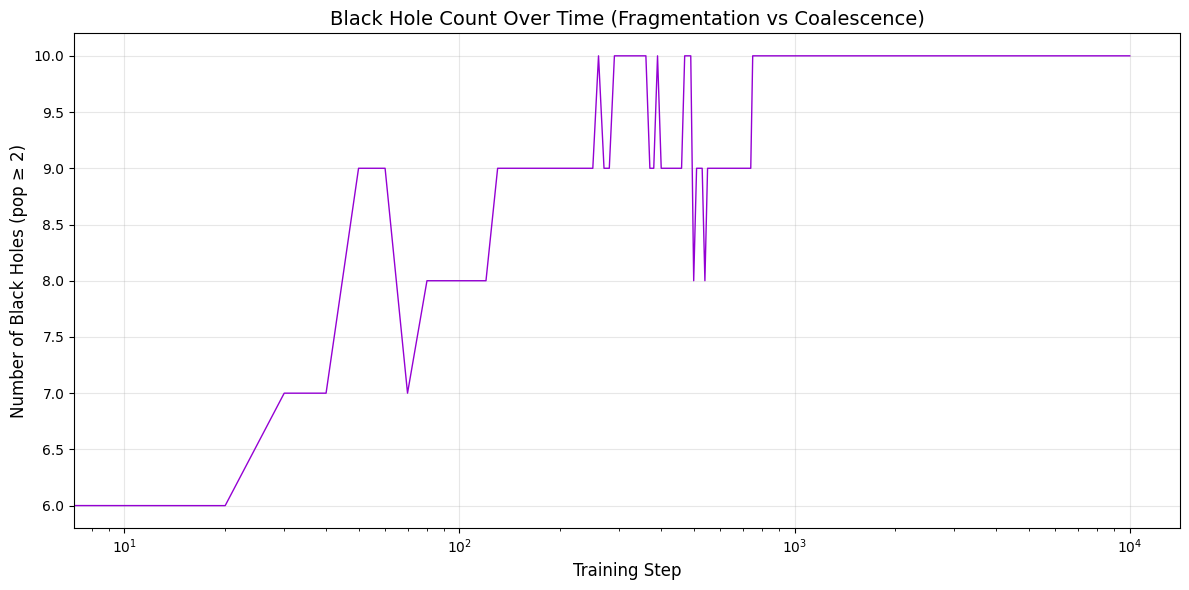


✓ Black hole count plot complete


In [55]:
n_black_holes_over_time = [len(d) for d in demographics_over_time]

fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

ax.plot(recorded_steps, n_black_holes_over_time, linewidth=1, color='darkviolet')
ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Number of Black Holes (pop ≥ 2)', fontsize=12)
ax.set_title('Black Hole Count Over Time (Fragmentation vs Coalescence)', fontsize=14)
ax.grid(alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.show()

print(f"\n✓ Black hole count plot complete")

## Plot 4: Herfindahl Index Over Time (Inequality Measure)

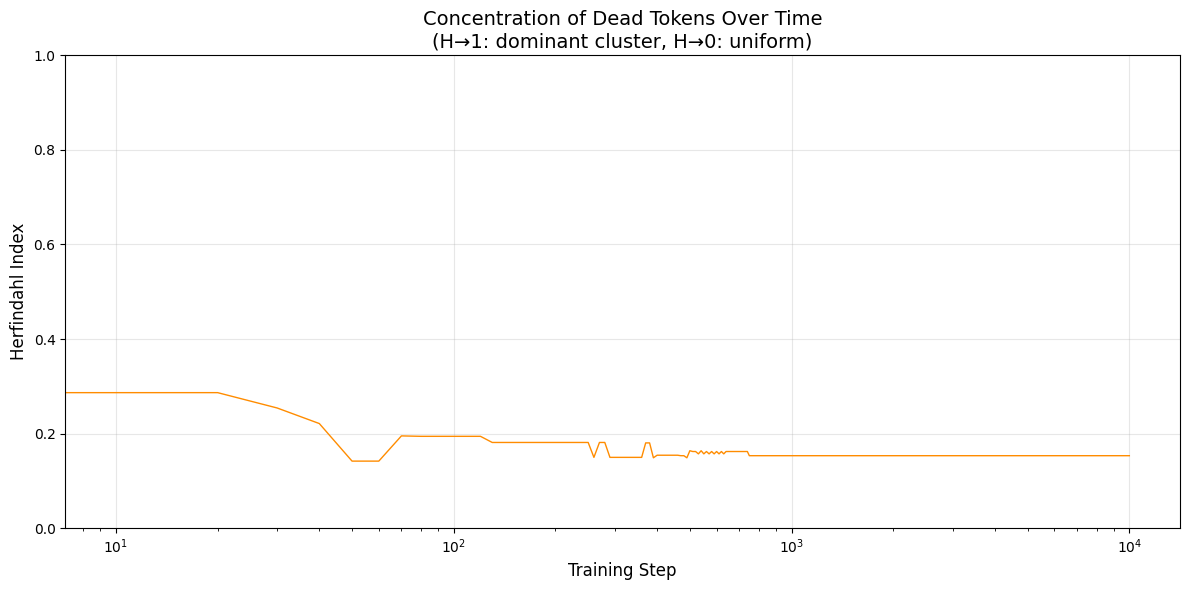


✓ Herfindahl index plot complete


In [56]:
def herfindahl_index(populations):
    """
    Compute Herfindahl index: H = Σ(p_i²) where p_i is fraction in black hole i.
    H → 1: one dominant black hole (high concentration)
    H → 0: uniform distribution (low concentration)
    """
    if len(populations) == 0:
        return 0
    total = sum(populations)
    if total == 0:
        return 0
    fractions = [p / total for p in populations]
    return sum(f**2 for f in fractions)

herfindahl_over_time = [herfindahl_index(d) for d in demographics_over_time]

fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

ax.plot(recorded_steps, herfindahl_over_time, linewidth=1, color='darkorange')
ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Herfindahl Index', fontsize=12)
ax.set_title('Concentration of Dead Tokens Over Time\n(H→1: dominant cluster, H→0: uniform)', fontsize=14)
ax.grid(alpha=0.3)
ax.set_ylim([0, 1])
ax.set_xscale('log')

plt.tight_layout()
plt.show()

print(f"\n✓ Herfindahl index plot complete")

## Statistics

In [57]:
print(f"\n{'='*80}")
print(f"BLACK HOLE DEMOGRAPHICS SUMMARY")
print(f"{'='*80}\n")

print(f"Initial state (step {recorded_steps[0]}):")
print(f"  Black holes: {len(initial_demographics)}")
if len(initial_demographics) > 0:
    print(f"  Largest: {initial_demographics[0]}")
    print(f"  Demographics: {initial_demographics[:10]}{'...' if len(initial_demographics) > 10 else ''}")
    print(f"  Total tokens in black holes: {sum(initial_demographics)}")
    print(f"  Herfindahl: {herfindahl_over_time[0]:.4f}")
else:
    print(f"  No black holes at step {recorded_steps[0]}")

print(f"\nFinal state (step {recorded_steps[-1]}):")
print(f"  Black holes: {len(final_demographics)}")
if len(final_demographics) > 0:
    print(f"  Largest: {final_demographics[0]}")
    print(f"  Demographics: {final_demographics[:10]}{'...' if len(final_demographics) > 10 else ''}")
    print(f"  Total tokens in black holes: {sum(final_demographics)}")
    print(f"  Herfindahl: {herfindahl_over_time[-1]:.4f}")
else:
    print(f"  No black holes at final step")

print(f"\nChange:")
print(f"  Black holes: {len(final_demographics) - len(initial_demographics):+d}")
if len(initial_demographics) > 0 and len(final_demographics) > 0:
    print(f"  Largest cluster growth: {final_demographics[0] - initial_demographics[0]:+d}")
    print(f"  Herfindahl change: {herfindahl_over_time[-1] - herfindahl_over_time[0]:+.4f}")

print(f"\n{'='*80}")


BLACK HOLE DEMOGRAPHICS SUMMARY

Initial state (step 0):
  Black holes: 8
  Largest: 15
  Demographics: [15, 9, 7, 5, 4, 3, 3, 2]
  Total tokens in black holes: 48
  Herfindahl: 0.1814

Final state (step 10000):
  Black holes: 10
  Largest: 10
  Demographics: [10, 8, 6, 3, 2, 2, 2, 2, 2, 2]
  Total tokens in black holes: 39
  Herfindahl: 0.1532

Change:
  Black holes: +2
  Largest cluster growth: -5
  Herfindahl change: -0.0282



## Interpretation

**What we're looking for:**

1. **Ranked populations plot**: Do lines cross (unstable hierarchy) or stay parallel (stable hierarchy)?
2. **Demographics comparison**: Does final state show power-law distribution (few large, many small)?
3. **Black hole count**: Does it increase (fragmentation) or decrease (coalescence)?
4. **Herfindahl index**: Does it increase (one cluster dominates) or decrease (spread out)?

**Expected Brownian dynamics:**
- Random walk → occasional collisions → black holes form
- Larger black holes are "stickier" (more likely to capture wanderers)
- Rich-get-richer dynamics → power-law distribution
- But also random fragmentation as tokens quantum-tunnel out